In [2]:
import pandas as pd

### The training set contains 115,886 Twitter users and 3,844,612 updates from the users. All the locations of the users are self-labeled in United States in city-level granularity.

### The test set contains 5,136 Twitter users and 5,156,047 tweets from the users. All the locations of users are uploaded from their smart phones with the form of ”UT: Latitude,Longitude”

In [3]:
# read tweet data
tweet_df = pd.read_csv('../00_data/01_raw/twitter_cikm_2010/training_set_tweets.txt', 
                 sep='\t', header=None, names=["UserID", "TweetID", "Tweet", "CreatedAt"],
                on_bad_lines='skip',low_memory=False)

tweet_df.head()

,UserID,TweetID,Tweet,CreatedAt
0,60730027,6320951896,@thediscovietnam coo. thanks. just dropped yo...,2009-12-03 18:41:07
1,60730027,6320673258,@thediscovietnam shit it ain't lettin me DM yo...,2009-12-03 18:31:01
2,60730027,6319871652,"@thediscovietnam hey cody, quick question...ca...",2009-12-03 18:01:51
3,60730027,6318151501,@smokinvinyl dang. you need anything? I got ...,2009-12-03 17:00:16
4,60730027,6317932721,"maybe i'm late in the game on this one, but th...",2009-12-03 16:52:36


In [4]:
# read user location data
user_df = pd.read_csv('../00_data/01_raw/twitter_cikm_2010/training_set_users.txt', 
                 sep='\t', header=None, names=["UserID", "UserLocation"],
                on_bad_lines='skip',low_memory=False)

user_df.head()

,UserID,UserLocation
0,14,San Francisco
1,15,San Francisco
2,18,"San Francisco, CA"
3,19922973,"Chicago, IL"
4,63963170,New York


-----

# Data Quaility check

## 1. How many users are in the data set?

In [5]:
print('There are',len(tweet_df['UserID'].unique()), "users data in Tweet dataset")
print('There are',len(user_df['UserID'].unique()), "users data in User location dataset")

There are 162238 users data in Tweet dataset
There are 108421 users data in User location dataset


Note: no need to predict the depression for users without location.

# 2. Does each user have only one location?

In [6]:
user_clean = user_df.copy().drop_duplicates()
user_clean[['City', 'State']] = user_clean['UserLocation'].str.split(', ', expand=True)
user_clean['UserID'] = user_clean['UserID'].astype(str)

In [7]:
user_clean.isna().sum()

UserID              0
UserLocation        0
City                0
State           37532
dtype: int64

In [8]:
user_clean.loc[user_clean['UserID'] == 770759]

,UserID,UserLocation,City,State


There are some data quaility issue:
- State data missing
- Different spelling of city and state
- !! One UserID map to multiple city
But we can on hold because we will only focus on city with enough data points, check the data quaily issue for that scope will reduce the work.

# 3. How many city have enough data point to go?

In [9]:
# Unique cities and states
unique_cities = user_clean['City'].nunique()
print(f"\nUnique Cities: {unique_cities}")


Unique Cities: 2711


In [10]:
# Get the frequency distribution of cities
city_distribution = pd.DataFrame(user_clean['City'].value_counts().reset_index())

# Summary statistics of the city distribution
print("\nSummary Statistics of City Distribution:")
city_distribution.describe()


Summary Statistics of City Distribution:


,count
count,2711.000000
mean,40.038731
std,260.456303
min,1.000000
25%,2.000000
50%,5.000000
75%,14.000000
max,7470.000000


In [11]:
city_distribution.loc[city_distribution['count']>50]

,City,count
0,Los Angeles,7470
1,New York,6560
2,Chicago,4230
3,Atlanta,3198
4,San Francisco,3115
...,...,...
252,Worcester,51
253,Hoboken,51
254,Yorkshire,51
255,Frisco,51


In [12]:
city_distribution.loc[city_distribution['count']>100]

,City,count
0,Los Angeles,7470
1,New York,6560
2,Chicago,4230
3,Atlanta,3198
4,San Francisco,3115
...,...,...
147,Naples,104
148,Bakersfield,103
149,Anaheim,101
150,Alexandria,101


In [13]:
city_distribution.loc[city_distribution['count']>1000]

,City,count
0,Los Angeles,7470
1,New York,6560
2,Chicago,4230
3,Atlanta,3198
4,San Francisco,3115
5,San Diego,2581
6,Boston,2112
7,Seattle,2005
8,Houston,1717
9,Las Vegas,1672


# 4. How many tweets one user havs on average?

In [14]:
tweet_clean = tweet_df.copy()
tweet_clean = tweet_clean.loc[tweet_clean['UserID'].isin(user_clean['UserID'])].dropna(subset=['Tweet'])

In [15]:
tweet_clean

,UserID,TweetID,Tweet,CreatedAt
0,60730027,6320951896,@thediscovietnam coo. thanks. just dropped yo...,2009-12-03 18:41:07
1,60730027,6320673258,@thediscovietnam shit it ain't lettin me DM yo...,2009-12-03 18:31:01
2,60730027,6319871652,"@thediscovietnam hey cody, quick question...ca...",2009-12-03 18:01:51
3,60730027,6318151501,@smokinvinyl dang. you need anything? I got ...,2009-12-03 17:00:16
4,60730027,6317932721,"maybe i'm late in the game on this one, but th...",2009-12-03 16:52:36
...,...,...,...,...
3807579,70604115,4069453413,what bees make milk?? ...,2009-09-17 21:09:00
3807580,70604115,4110581088,boredd as tits.,2009-09-19 16:09:00
3807581,70604115,4157306930,"oh god heroes tonight, ... http://lnk.ms/0ShgX",2009-09-21 17:09:00
3807582,70604115,4161226012,tits i'm bored,2009-09-21 20:09:00


In [16]:
# Get the frequency distribution of cities
tweet_distribution = tweet_clean.groupby(['UserID']).agg({'Tweet': 'count'}).reset_index()

# Summary statistics of the city distribution
print("\nSummary Statistics of Tweet Distribution:")
tweet_distribution.describe()


Summary Statistics of Tweet Distribution:


,Tweet
count,101173.000000
mean,36.837921
std,29.168976
min,1.000000
25%,20.000000
50%,32.000000
75%,40.000000
max,400.000000


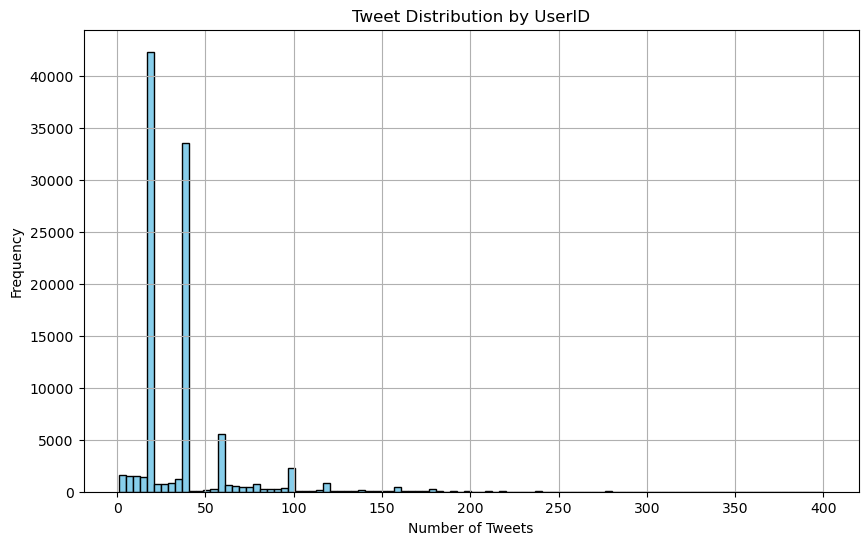

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(tweet_distribution['Tweet'], bins=100, color='skyblue', edgecolor='black')
plt.title('Tweet Distribution by UserID')
plt.xlabel('Number of Tweets')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [18]:
tweet_clean = tweet_clean.groupby('UserID').filter(lambda x: len(x) >= 15)

In [19]:
tweet_clean

,UserID,TweetID,Tweet,CreatedAt
0,60730027,6320951896,@thediscovietnam coo. thanks. just dropped yo...,2009-12-03 18:41:07
1,60730027,6320673258,@thediscovietnam shit it ain't lettin me DM yo...,2009-12-03 18:31:01
2,60730027,6319871652,"@thediscovietnam hey cody, quick question...ca...",2009-12-03 18:01:51
3,60730027,6318151501,@smokinvinyl dang. you need anything? I got ...,2009-12-03 17:00:16
4,60730027,6317932721,"maybe i'm late in the game on this one, but th...",2009-12-03 16:52:36
...,...,...,...,...
3807570,15728619,4319728279,NOT listening to Too Short.,2009-09-23 11:57:54
3807571,15728619,4320527215,@street3 Taco taco taco. Burrito.,2009-09-23 12:33:22
3807572,15728619,4321743768,Nap time? After food time. I'm like a baby. Or...,2009-09-23 13:29:02
3807573,15728619,4321843156,.@AxisGranted Many have been threatening that ...,2009-09-23 13:33:39


In [20]:
#input of depression detector: [Tweet_ID, created_at, text]
# Create a new 'Tweet_ID' by combining 'UserID' and 'TweetID' with an underscore
#tweet_clean['Tweet_ID'] = tweet_clean['UserID'].astype(str) + "_" + tweet_clean['TweetID'].astype(str)

# Select the relevant columns: 'Tweet_ID', 'CreatedAt' (renaming to 'created_at'), and 'Tweet' (renaming to 'text')
processed_tweets = tweet_clean[['UserID','TweetID', 'CreatedAt', 'Tweet']].rename(columns={'UserID':'user_id','CreatedAt': 'created_at', 'Tweet': 'text'})

# Display the first few rows of the processed DataFrame
processed_tweets.head()

,user_id,TweetID,created_at,text
0,60730027,6320951896,2009-12-03 18:41:07,@thediscovietnam coo. thanks. just dropped yo...
1,60730027,6320673258,2009-12-03 18:31:01,@thediscovietnam shit it ain't lettin me DM yo...
2,60730027,6319871652,2009-12-03 18:01:51,"@thediscovietnam hey cody, quick question...ca..."
3,60730027,6318151501,2009-12-03 17:00:16,@smokinvinyl dang. you need anything? I got ...
4,60730027,6317932721,2009-12-03 16:52:36,"maybe i'm late in the game on this one, but th..."


In [21]:
processed_tweets.dtypes

user_id       object
TweetID       object
created_at    object
text          object
dtype: object

In [22]:
processed_tweets.to_csv('../00_data/02_intermediate/training_set_tweets.csv',index=False)

____

In [23]:
user_clean

,UserID,UserLocation,City,State
0,14,San Francisco,San Francisco,None
1,15,San Francisco,San Francisco,None
2,18,"San Francisco, CA",San Francisco,CA
3,19922973,"Chicago, IL",Chicago,IL
4,63963170,New York,New York,None
...,...,...,...,...
115878,72351647,Los Angeles,Los Angeles,None
115882,18000542,"Dallas, TX",Dallas,TX
115883,55574468,"Pensacola, FL",Pensacola,FL
115884,15728619,"Woburn, Massachusetts",Woburn,Massachusetts


In [24]:
import pandas as pd

data = pd.read_csv('../00_data/01_raw/twitter19_cbsa_depression_rates.csv')



In [25]:
column_names = ['User_ID', 'created_at', 'location', 'lat','lon','text']  # Replace with actual column names
data = pd.read_csv('../00_data/01_raw/GeoText.2010-10-12/full_text.txt', sep='\t', encoding='ISO-8859-1', header=None, names=column_names)

In [26]:
processed_tweets = tweet_clean[['UserID','TweetID', 'CreatedAt', 'Tweet']]

In [27]:
data

,User_ID,created_at,location,lat,lon,text
0,USER_79321756,2010-03-03T04:15:26,"ÃT: 47.528139,-122.197916",47.528139,-122.197916,RT @USER_2ff4faca: IF SHE DO IT 1 MORE TIME......
1,USER_79321756,2010-03-03T04:55:32,"ÃT: 47.528139,-122.197916",47.528139,-122.197916,@USER_77a4822d @USER_2ff4faca okay:) lol. Sayi...
2,USER_79321756,2010-03-03T05:13:34,"ÃT: 47.528139,-122.197916",47.528139,-122.197916,RT @USER_5d4d777a: YOURE A FAG FOR GETTING IN ...
3,USER_79321756,2010-03-03T05:28:02,"ÃT: 47.528139,-122.197916",47.528139,-122.197916,@USER_77a4822d yea ok..well answer that cheap ...
4,USER_79321756,2010-03-03T05:56:13,"ÃT: 47.528139,-122.197916",47.528139,-122.197916,A sprite can disappear in her mouth - lil kim ...
...,...,...,...,...,...,...
376506,USER_8c704efa,2010-03-06T17:51:27,"ÃT: 39.955937,-75.159995",39.955937,-75.159995,@USER_6771261c Thanxx pumpkinnn
376507,USER_8c704efa,2010-03-06T18:49:45,"ÃT: 39.955937,-75.159995",39.955937,-75.159995,Oooh and the Nudiesssss
376508,USER_8c704efa,2010-03-06T19:03:48,"ÃT: 39.955937,-75.159995",39.955937,-75.159995,I just wanna sing!!!!! Its maddd people here! =(
376509,USER_8c704efa,2010-03-06T19:19:05,"ÃT: 39.955937,-75.159995",39.955937,-75.159995,ThanxXx babyluvv RT @USER_d18b3d00: @USER_8c70...


In [28]:
data.loc[data['Depression']==1]

KeyError: 'Depression'